In [69]:
#### A: main code ####

import os
import sys
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
import time
from IPython.display import clear_output

class Env:
    def __init__(self, map_size, dist, side, step_limit, bound=None, f1_rate=None, f2_rate=None, 
                 r_f2=None, r_f1=None, r_0=None, r_out=None, r_close=None, r_far=None):
        # environment paras
        self.map_size   = map_size
        self.dist       = dist       # distance btw robot and fire scene
        self.side       = side       # side length of the square fire scene
        self.f1_rate    = f1_rate    # level 1 fire rate
        self.f2_rate    = f2_rate    # level 2 fire rate
        self.rows       = self.map_size[0]
        self.cols       = self.map_size[1]
        self.case_map   = None       # saved fire map 
        self.curr_map   = None       # fire map without agent
        self.cell_size  = self.side/self.rows # size of discrete cell
        self.origin     = [self.side/2, self.side/2]  # initial position of robot
        self.ori_state  = [int(self.rows//2), int(self.cols//2)]  # initial state of robot
        self.done       = False      # whether an episode is done
        # reward
        self.r_f2       = r_f2       # reward of reaching level 2 fire
        self.r_f1       = r_f1       # reward of reaching level 1 fire
        self.r_0        = r_0        # reward of reaching "0" states
        self.r_out      = r_out      # out-of-range reward
        self.r_close    = r_close    # reward of an action going towards the goal
        self.r_far      = r_far      # reward of an action not going towards the goal
        # fire
        self.f1_num   = int(self.rows*self.cols*self.f1_rate)
        self.f2_num   = int(self.rows*self.cols*self.f2_rate)
        self.f_num    = self.f1_num+self.f2_num # number of fires
        self.f_done   = 0 # number of fires being put out
        self.f_pos    = None
        self.f1_pos   = None
        self.f2_pos   = None
        # agent
        self.curr_pos   = self.origin    # continuous state
        self.curr_state = self.ori_state # discrete state
        self.angle_x    = 0              # angle along col
        self.angle_y    = 0              # angle along row
        self.step_num   = 0
        self.agent_pv   = 10             # display value of the agent in the map
        self.bound      = bound          # angle limit
        self.step_limit = step_limit
        self.target     = None           # local target
        self.target_d   = None

    def create_map(self, f=None):
        if f == None:
            # create fires
            self.f_pos = np.random.choice(self.rows*self.cols, size=self.f1_num+self.f2_num, replace=False)
            self.f1_pos = np.random.choice(self.f_pos, size=self.f1_num, replace=False)
            self.f2_pos = list((i for i in self.f_pos if i not in self.f1_pos))
        else:
            self.f_pos = np.array(f)
            self.f1_pos = np.random.choice(self.f_pos, size=self.f1_num, replace=False)
            self.f2_pos = list((i for i in self.f_pos if i not in self.f1_pos))
        # create map
        m = np.zeros(self.map_size)
        for i in range(self.rows):
            for j in range(self.cols):
                if self.rows*i+j in self.f1_pos:
                    m[i][j] = int(1)
                elif self.rows*i+j in self.f2_pos:
                    m[i][j] = int(2)
                else:
                    m[i][j] = int(0)
        self.case_map = m
        self.curr_map = self.case_map.copy()
        
    def make_obs(self): # return a map with agent position
        m = self.curr_map.copy()
        m[self.curr_state[0]][self.curr_state[1]] = self.agent_pv
        return m
    
    def find_nearest(self, grid, state): # find a current local nearest goal
        min_dist = 999
        goal = None
        for i in range(self.rows):
            for j in range(self.cols):
                if grid[i][j] != 0:
                    dist = ((i-state[0])**2+(j-state[1])**2)**(1/2)
                    if dist < min_dist:
                        min_dist = dist
                        goal = [i, j]
        if goal == None:
            print("Could not find a goal.")
            sys.exit()
        return goal, min_dist
        
    def step(self, mu): 
        self.step_num += 1
        state = self.curr_state
        pos = self.curr_pos
        
        # action
        action = mu  # mu = actor network output
        action = action*self.bound
        action = action.tolist() # [-bound, bound]
        
        # next angle to be updated
        ay = self.angle_y + action[0] 
        ax = self.angle_x + action[1]
        # next distance from upper-left position
        y = self.origin[0]+self.dist*math.tan(ay*math.pi/180) 
        x = self.origin[1]+self.dist*math.tan(ax*math.pi/180)
        # next coordinates from upper-left state
        s1 = int(y//self.cell_size) 
        s2 = int(x//self.cell_size)
        state_ = [s1, s2]
        pos_ = [y, x]
        
        # check validation, move, get reward
        if y<0 or y>self.side or x<0 or x>self.side:
#             print("OUT OF RANGE")
            reward = self.r_out
        else:
            # move
            self.curr_pos = pos_
            self.curr_state = [s1,s2]
            self.angle_y += action[0]
            self.angle_x += action[1]
            # get reward
            if self.target == None:
                temp = (np.array(pos)/self.cell_size).tolist()
                goal_state, goal_dist = self.find_nearest(self.curr_map, temp)
                self.target = goal_state
            curr_dist = ((pos[0]/self.cell_size-self.target[0])**2+
                         (pos[1]/self.cell_size-self.target[1])**2)**(1/2)
            next_dist = ((pos_[0]/self.cell_size-self.target[0])**2+
                         (pos_[1]/self.cell_size-self.target[1])**2)**(1/2)
            reward = (curr_dist-next_dist)*10
            # reset target when it's found
            if state_ == self.target:
                self.target = None
            # put out fire
            if self.curr_map[s1][s2] != 0:
                self.curr_map[s1][s2] = 0
                self.f_done += 1
        
        self.render()
        print("Step:   ", self.step_num)
        print("State:  ", state)
        print("Target: ", self.target)
        print("Action: ", action)
        print("Reward: ", reward)
        
        # check done
        if self.f_done == self.f_num or self.step_num == self.step_limit:
            self.done = True
        
        return self.make_obs(), reward, self.done
        
    def render(self):
        m = self.make_obs()
        print(m)
        
    def reset(self):
        self.curr_map = self.case_map.copy()
        self.curr_state = self.ori_state
        self.curr_pos = self.origin
        self.angle_x = 0
        self.angle_y = 0
        self.f_done = 0
        self.done = False
        self.step_num = 0
        self.target = None
        obs = self.make_obs()
        return obs

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done # to facilitate the bellman update equation
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]
        return states, actions, rewards, states_, terminal
    
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

class CriticNetwork(nn.Module):
    def __init__(self, lr_c, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/ddpg'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        f1 = 0.003
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1) # initialize weights & bias in a narrow range
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)
        
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 0.003
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        self.fc3 = nn.Linear(self.n_actions, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, 1)
        f3 = 0.003
        T.nn.init.uniform_(self.q.weight.data, -f3, f3)
        T.nn.init.uniform_(self.q.bias.data, -f3, f3)
        self.q.weight.data.uniform_(-f3, f3)
        self.q.bias.data.uniform_(-f3, f3)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr_c)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        action_value = F.relu(self.fc3(action))
        state_action_value = F.relu(T.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class ActorNetwork(nn.Module):
    def __init__(self, lr_a, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        
        self.stack = nn.Sequential(
            nn.Linear(self.input_dims, self.fc1_dims),
            nn.ReLU(),
            nn.Linear(self.fc1_dims, self.fc2_dims),
            nn.ReLU(),
            nn.Linear(self.fc2_dims, self.n_actions),
            nn.Tanh()
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr_a)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        x = self.stack(state)
        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

class Agent(object):
    def __init__(self, lr_a, lr_c, input_dims, tau, env, gamma, n_actions, 
                 max_size, layer1_size, layer2_size, batch_size):
        self.gamma = gamma
        self.tau = tau
        self.input_dims = input_dims
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.actor = ActorNetwork(lr_a, input_dims, layer1_size, layer2_size, 
                                  n_actions=n_actions, name='Actor')
        self.critic = CriticNetwork(lr_c, input_dims, layer1_size, layer2_size, 
                                    n_actions=n_actions, name='Critic')
        self.target_actor = ActorNetwork(lr_a, input_dims, layer1_size, layer2_size, 
                                         n_actions=n_actions, name='TargetActor')
        self.target_critic = CriticNetwork(lr_c, input_dims, layer1_size, layer2_size, 
                                           n_actions=n_actions, name='TargetCritic')
        self.noise = OUActionNoise(mu=np.zeros(n_actions))
        self.loss_a = []
        self.loss_c = []
        self.update_network_parameters()

    def choose_action(self, obs):
        self.actor.eval()
        obs = T.tensor(obs, dtype=T.float)
        obs = obs.view(self.input_dims)
        mu = self.actor.forward(obs)
        mu_prime = mu + T.tensor(self.noise(), dtype=T.float)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
        
        reward = T.tensor(reward, dtype=T.float)
        done = T.tensor(done)
        new_state = T.tensor(new_state, dtype=T.float)
        action = T.tensor(action, dtype=T.float)
        state = T.tensor(state, dtype=T.float)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)
        
        # obtain target value
        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma * critic_value_[j] * done[j])
        target = T.tensor(target)
        target = target.view(self.batch_size, 1)

        # critic
        self.critic.train() 
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value) # loss calculation
        critic_loss.backward() # backpropagate
        self.critic.optimizer.step() # update the network
        self.critic.eval()
        
        # actor
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.loss_a.append(actor_loss)
        self.loss_c.append(critic_loss)
        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau
        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()
        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)
        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_dict[name].clone()
        self.target_critic.load_state_dict(critic_state_dict)
        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                     (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)
        
    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

In [70]:
#### B: helper functions ####

import matplotlib.pyplot as plt 
import numpy as np

def flatten(x): # flatten a list
    y = np.array(x).reshape((1,-1))
    y = y.tolist()
    return y[0]

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def greedy_choice(mu, eps):
    max_index = mu.index(max(mu))
    probs = []
    for i in range(4):
        if i == max_index:
            probs.append(1-eps+eps/len(mu))
        else:
            probs.append(eps/len(mu))
    return np.random.choice([0,1,2,3], p=probs)

def ploting(scores, y='Total reward', x=None, window=100):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel(y)       
    plt.xlabel('Episodes')                     
    plt.plot(x, running_avg)
    
def plotLoss(scores, filename, x=None, window=5):   
    l = []
    for i in range(len(scores)):
        l.append(scores[i].tolist())
    plt.ylabel('Loss')       
    plt.xlabel('Episodes')                     
    plt.plot(l)
    plt.savefig(filename)
    
def plot_tensor(x):
    l = []
    for i in range(len(x)):
        if i % 20 == 0:
            l.append(x[i].tolist()) 
    ploting(l, y="Loss", window=100)

In [71]:
#### C: initialization ####

# environment paras
MAP_SIZE     = (5,5)   # [row_n, col_n]
DISTANCE     = 5       # distance between robot and fire scene
SIDE_LENGTH  = 15      # side length of the square scene
F1_RATE      = 0       # level 1 fire rate
F2_RATE      = 0.2     # level 2 fire rate
# STEP_LIMIT   = MAP_SIZE[0]*MAP_SIZE[1]*2
STEP_LIMIT   = 200
REWARD_F2    = 10      # reward of reaching level 2 fire
REWARD_F1    = 5       # reward of reaching level 1 fire
REWARD_0     = -1      # reward of reaching "0" states
REWARD_OUT   = -1      # out-of-range reward
R_CLOSE      = 10      # reward of an action going towards the goal
R_FAR        = -10     # reward of an action not going towards the goal

# agent paras
LR_ACTOR     = 0.001
LR_CRITIC    = 0.001
TAU          = 0.001
GAMMA        = 0.99
MEMORY       = 10000
BATCH        = 5
BOUND        = 5

INPUT        = MAP_SIZE[0]*MAP_SIZE[1]
LAYER1       = INPUT*2
LAYER2       = INPUT*2
OUTPUT       = 2

# create environment
env = Env(map_size=MAP_SIZE, dist=DISTANCE, side=SIDE_LENGTH, bound=BOUND,
          f1_rate=F1_RATE, f2_rate=F2_RATE, step_limit=STEP_LIMIT, 
          r_f2=REWARD_F2, r_f1=REWARD_F1, r_0=REWARD_0, r_out=REWARD_OUT, r_close=R_CLOSE, r_far=R_FAR)
env.create_map(f=[4, 9, 18, 17, 14])
# env.create_map() # create a random map
# create agent
agent = Agent(lr_a=LR_ACTOR, lr_c=LR_CRITIC, input_dims=INPUT, tau=TAU, env=env, gamma=GAMMA, 
              max_size=MEMORY, batch_size=BATCH,  layer1_size=LAYER1, layer2_size=LAYER2, n_actions=OUTPUT)

reward_history = []       # list of averaged reward in an episode
reward_history_sum = []   # list of accumulated reward in an episode
f_done_list = []          # list of the number of goal being found in an episode
print(env.case_map)

[[0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 2.]
 [0. 0. 2. 2. 0.]
 [0. 0. 0. 0. 0.]]


In [ ]:
#### D: load model ####

agent.load_models()

In [137]:
#### E: training ####

env.step_limit = 100 # change the step limit
episode_num = 100    # the number of episodes for training

for i in range(episode_num):
    obs = env.reset()
    done = False
    reward_sum = 0
    while not done:
        action = agent.choose_action(obs)
        new_obs, reward, done = env.step(action)
        agent.remember(flatten(obs), action, reward, flatten(new_obs), int(done))
        agent.learn()
        reward_sum += reward
        obs = new_obs
        
#         time.sleep(0.5) # slow down to see how it moves
        clear_output(wait=True)
        print("Episode:", i)
    f_done_list.append(env.f_done)
    reward_history.append(reward_sum/env.step_num)
    reward_history_sum.append(reward_sum)

Episode: 0


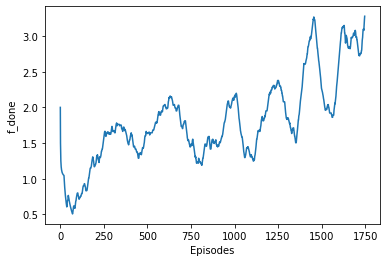

In [132]:
#### F: five plots ####

ploting(f_done_list, "f_done", window=100)

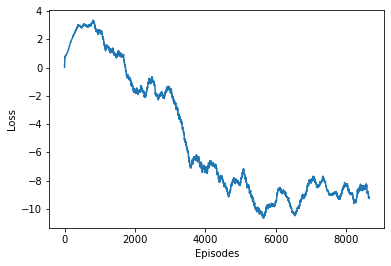

In [133]:
plot_tensor(agent.loss_a)

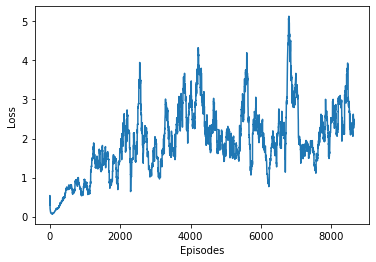

In [134]:
plot_tensor(agent.loss_c)

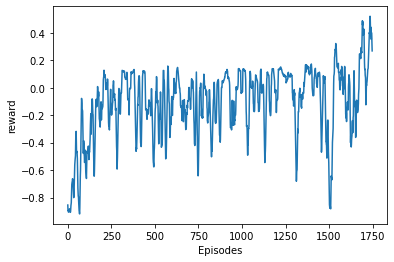

In [135]:
ploting(reward_history, "reward", window=10)

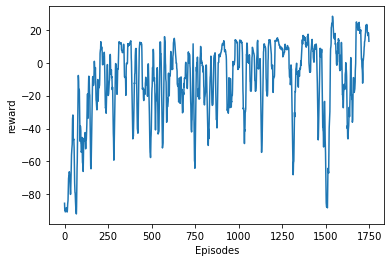

In [136]:
ploting(reward_history_sum, "reward", window=10)

In [131]:
#### G: testing ####

obs = env.reset()
done = False
while not done:
    action = agent.choose_action(obs)
    new_obs, reward, done = env.step(action)
    obs = new_obs
    time.sleep(0.1) # slow down to see how it moves
    clear_output(wait=True)

[[ 0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0. 10.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Step:    100
State:   [2, 3]
Target:  [1, 4]
Action:  [-5.749948024749756, 6.960666179656982]
Reward:  1.6347605841044222


In [130]:
#### H: save model ####

agent.save_models()

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
